<a href="https://colab.research.google.com/github/andersoncruzz/SSFER/blob/master/teste_video_intelbras_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/andersoncruzz/SSFER.git

Cloning into 'SSFER'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 176 (delta 15), reused 27 (delta 6), pack-reused 130
Receiving objects: 100% (176/176), 300.73 KiB | 1.07 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [0]:
!cd SSFER; ls; git pull origin master

classifiers				__pycache__
colab					README.md
emojis					requeriments.txt
experiment.sh				results
exp_face_detector.py			show_poc.py
faceDetector				split_database.py
generate_db_VOC.py			test_model.py
generate_db_with_faces_extracted.py	train_classifiers.py
how_to_install_emotion_recognition.txt	train_colab.ipynb
__init__.py				utils
preProcessing
From https://github.com/andersoncruzz/SSFER
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
!apt install cmake
!pip install face_recognition
!pip install mtcnn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cmake-data libarchive13 libjsoncpp1 liblzo2-2 librhash0 libuv1
Suggested packages:
  cmake-doc ninja-build lrzip
The following NEW packages will be installed:
  cmake cmake-data libarchive13 libjsoncpp1 liblzo2-2 librhash0 libuv1
0 upgraded, 7 newly installed, 0 to remove and 8 not upgraded.
Need to get 5,023 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 liblzo2-2 amd64 2.08-1.2 [48.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 cmake-data all 3.10.2-1ubuntu2 [1,331 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libarchive13 amd64 3.2.2-3.1ubuntu0.1 [289 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjsoncpp1 amd64 1.7.4-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 

In [0]:
!ls
!touch SSFER/__init__.py

from SSFER.faceDetector.faceDetector import FaceDetector

drive  sample_data  SSFER


# Drive mount

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Model

In [0]:
# !pip install keras
from keras.models import load_model
import os

DRIVE_ROOT = "/content/drive/My Drive/"
PATH_MODEL = "SSFER_models/vgg_19_weights_110+03_18_51+2018-11-1.hdf5"
PATH_WEIGHTS = os.path.join(DRIVE_ROOT, PATH_MODEL ) 
model = load_model(PATH_WEIGHTS)

Using TensorFlow backend.


# Teste Video From Drive

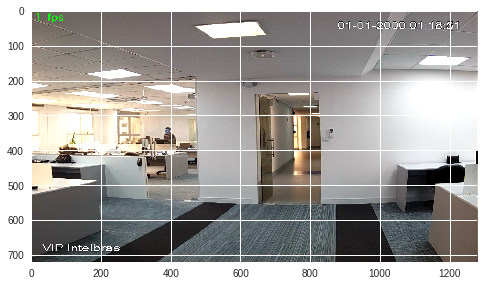

None

aqui:  207


In [0]:
# -*- coding: utf-8 -*-
import sys
import time

import cv2
from keras import backend as K
import keras
from keras.models import load_model
import sys, os
from SSFER.faceDetector.faceDetector import FaceDetector
import numpy as np

from IPython import display
import matplotlib.pyplot as plt

def padding_bounding_box(bb, img_size, padding=32):
    bounding_box = np.zeros(4, dtype=np.int32)

    bounding_box[0] = np.maximum(bb[3] - padding / 2, 0)
    bounding_box[1] = np.maximum(bb[0] - padding / 2, 0)
    bounding_box[2] = np.minimum(bb[1] + padding / 2, img_size[1])
    bounding_box[3] = np.minimum(bb[2] + padding / 2, img_size[0])

    return bounding_box


def get_emotion(net, img, coordinate):
    img_cropped = img[coordinate[0]:coordinate[2], coordinate[3]:coordinate[1]]

    img_cropped = cv2.resize(img_cropped, (110, 110))
    img_cropped = np.array(img_cropped)
    img_cropped = img_cropped.reshape(1, 110, 110, 3)
    predictions = net.predict([np.array(img_cropped)])
    index_emotion = np.argmax(predictions[0])

    return index_emotion

def ajust_point_on_view(point, img_size):
    if point + 120 > img_size:
        return point - (point + 120 - img_size)

    return point

def get_coordinate_emoji(bb, img_size):
    bounding_box = np.zeros(4, dtype=np.int32)

    bounding_box[0] = ajust_point_on_view(bb[0], img_size[1])
    bounding_box[1] = ajust_point_on_view(bb[1], img_size[0])
    bounding_box[2] = bb[0] + 120
    bounding_box[3] = bb[1] + 120

    return bounding_box

def classify(net, img, faceDetector, img_size):
    faces = []
    print("aqui 1")
    coordinates = faceDetector.detectHogSVM(img)
    print("aqui 2")
    
    for coordinate in coordinates:
        face = {}
        face["bounding_box"] = padding_bounding_box(coordinate, img_size)
        face["emotion"] = get_emotion(net, img, coordinate)
        faces.append(face)

    return faces

def add_overlays(frame, faces, frame_rate, EMOTIONS, feelings_faces, img_size):
    if faces is not None:
        for face in faces:
            face_bb = face["bounding_box"]
            cv2.rectangle(frame,
                          (face_bb[0], face_bb[1]), (face_bb[2], face_bb[3]),
                          (0, 255, 0), 6)
            if face["emotion"] is not None:
                # print("Person: ", face.name)
                cv2.putText(frame, EMOTIONS[face["emotion"]], (face_bb[0], face_bb[3]),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0),
                            thickness=2, lineType=6)

                emoji = feelings_faces[face["emotion"]]
                emoji_bb = get_coordinate_emoji(face_bb, img_size)
                # Ugly transparent fix
                for c in range(0, 3):
                    frame[emoji_bb[1]:emoji_bb[3], emoji_bb[0]:emoji_bb[2], c] = emoji[:,:,c] * (emoji[:, :, 3] // 255.0) +  frame[emoji_bb[1]:emoji_bb[3], emoji_bb[0]:emoji_bb[2], c] * (1.0 - emoji[:, :, 3] // 255.0)



    cv2.putText(frame, str(frame_rate) + " fps", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0),
                thickness=2, lineType=6)


def main():

    EMOTIONS = ['angry', 'disgusted', 'fearful', \
            'happy', 'sad', 'surprised', 'neutral']

    EMOTIONS_pt = ['raiva', 'desgosto', 'medo', \
            'felicidade', 'tristeza', 'surpresa', 'neutralidade']


    feelings_faces = []
    for index, emotion in enumerate(EMOTIONS):
        feelings_faces.append(cv2.imread('SSFER/emojis/' + emotion + '.png', -1))


#     PATH_NET_INPUT = "model/vgg_19_weights_110+03_18_51+2018-11-1.hdf5"
    DRIVE_ROOT = "/content/drive/My Drive/"
    PATH_MODEL = "SSFER_models/vgg_19_weights_110+03_18_51+2018-11-1.hdf5"
    PATH_NET_INPUT = os.path.join(DRIVE_ROOT, PATH_MODEL ) 

    
    frame_interval = 5  # Number of frames after which to run face detection
    fps_display_interval = 5  # seconds
    frame_rate = 0
    frame_count = 0
    
    VIDEO_PATH = "videos_intelbras_analise/20000101_011841.mp4"
    capture = os.path.join(DRIVE_ROOT, VIDEO_PATH)
    print("capture: ", capture)
    video_capture = cv2.VideoCapture(capture)
    print("[+] LOADING: ")

    net = load_model(PATH_NET_INPUT)

    faceDetector = FaceDetector(mtcnn=False)
    start_time = time.time()
    i = 0
    while (video_capture.isOpened()):
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("QUIT APPLICATION")
            break

        # Capture frame-by-frame
        ret, frame = video_capture.read()
        if frame is None:
          break
        frame = cv2.resize(frame, (1280, 720))
        img_size = np.asarray(frame.shape)[0:2]

        if (frame_count % frame_interval) == 0:
            faces = classify(net, frame, faceDetector, img_size)

            # Check our current fps
            end_time = time.time()
            if (end_time - start_time) > fps_display_interval:
                frame_rate = int(frame_count / (end_time - start_time))
                start_time = time.time()
                frame_count = 0

        add_overlays(frame, faces, frame_rate, EMOTIONS_pt, feelings_faces, img_size)

        frame_count += 1
#         cv2.imshow('Video', frame)
#         cv2.namedWindow("window", cv2.WND_PROP_FULLSCREEN)
#         cv2.setWindowProperty("window",cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_GUI_EXPANDED)
#         cv2.imshow("window", frame)
#         plt.figure(figsize=(20,20))
        plt.imshow(frame)
        display.clear_output(wait=False)
        display.display(plt.show())
        i += 1    
        print("aqui: ", i)        

    # When everything is done, release the capture
    video_capture.release()
    cv2.destroyAllWindows()



if __name__ == '__main__':
    main()


In [0]:
from IPython.display import HTML
HTML('<img width="560" height="315" src="/content/drive/My Drive/DSC00074.JPG">')

In [0]:
!ls /content/drive/My\ Drive/ | grep JPG

Analista de Gerência de Configuração de Software PlSR (SCM).JPG
DSC00074.JPG
DSC00075.JPG
